**Part 2 - Model in 2D for f_BW using the mapping closure**

This notebook implements the mapping closure developed by (Chen, H. 1989) and extended by (Pope, S.B. 1991) for a two-dimensional (2D) problem where the vector of random variables $\bm{Y} = (B,W)$ inlcues the buoyancy $B$ and the vertical velocity $W$.

*Evolution equation*

The joint pdf $f_{\bm{Y}}$ evolves according to the forward Kolmogorov equation given by

\begin{equation}
\frac{\partial f_{\bm{Y}} }{ \partial t}= -\frac{\partial }{\partial y_i} \bm{D}^{(1)}_i f_{\bm{Y}}  + \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}^{(2)}_{ij} f_{\bm{Y}},
\end{equation}

where 

\begin{equation}
  \bm{D}^{(1)}=
    \begin{pmatrix}
    0\\
    \mathbb{E}_{\bm{Y}_{t}} [B_t - \partial_{Z} P_{t}]\\
  \end{pmatrix}
  +
  \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega}
\begin{bmatrix}
  \alpha_{1}\,\bm{n}\cdot\nabla B_{t}\\
  \alpha_{2}\,\bm{n}\cdot\nabla W_{t}\\
\end{bmatrix} \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}}.
\end{equation}

arises due to diffusive fluxes at the boundary, which must be specified. In this case buoyancy forcing make a non-zero contribution to $\bm{D}^{(1)}$ while $\bm{n}\cdot\nabla W_{t} = 0$ for our system, due to no-slip boundary conditions and $\nabla \cdot \bm{U} = 0$ so we can discard this term. The diffusion term for our system us given by
\begin{equation}
  \bm{D}^{(2)}=-\frac{1}{2}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    2\alpha_{1}|\nabla B_{t}|^{2} & (\alpha_{1}+\alpha_{2})\nabla B_{t}\cdot\nabla W_{t} \\
    (\alpha_{1}+\alpha_{2})\nabla B_{t}\cdot\nabla W_{t} & 2\alpha_{2} |\nabla W_{t}|^{2}\\
  \end{bmatrix}.
\end{equation}
However to avail of the mapping closure (Pope, S.B. 1991) we will use to model these terms we will make the assumption that
\begin{equation}
  \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}_{ij}^{(2)} f_{\bm{Y}} \approx -\frac{\partial }{ \partial y_i} \mathbb{E}_{\bm{Y}_{t}} [ \alpha_{ij} \nabla^{2} \bm{Y}^j_{t}] f_{\bm{Y}},
\end{equation}
which at least for the 1D problem and for problems with periodic boundary conditions has shown to be equivalent. For now we consider only the unforced system when $\bm{D}^{(1)}_{i} = 0$ before later reintroducing these terms.

*Mapping closure*

Corresponding to the random vector $\bm{Y} = (Y_1,Y_2)$ we now have a vector of Gaussian random fields $\bm{\theta} = (\theta_1,\theta_2)$. The (now multidimensional) mapping $\mathscr{Y}_{\alpha}(-,t):\mathbb{R}^{\alpha} \rightarrow \mathbb{R}$ which maps the Gaussian field(s) to the surrogate field $\tilde{Y}_{\alpha}$ is hierarchical in the sense that 
\begin{align*}
    \tilde{Y}_1(\bm{x},t) &= \mathscr{Y}_{1}(\theta_1(J_1(t)\bm{x}),t), \\
    \tilde{Y}_2(\bm{x},t) &= \mathscr{Y}_{2}(\theta_1(J_1(t)\bm{x}),\theta_2(J_2(t)\bm{x}),t),
\end{align*}
such that $\mathscr{Y}_{\alpha}$ only depends on the subset $[\bm{\theta}]_{\alpha}$

*Mapping equation*

The mapping $\mathscr{Y}_{\alpha}(-,t)$ evolves according to

\begin{equation}
\frac{\partial \mathscr{Y}_{\alpha} }{\partial t} = \bm{D}^{(1)}_{\alpha} + \sum_{j=1}^{\alpha} \frac{\gamma_{\alpha}}{\tau_{j}(t)} \left( \frac{\partial^{2}}{\partial \eta_{j}^{2}} - \eta_{j}\frac{\partial }{ \partial \eta_{j} }\right)\mathscr{Y}_{\alpha},
\end{equation}

which when expanded is given by

\begin{align*}
\frac{\partial \mathscr{Y}_1 }{\partial t} &= \frac{\gamma_{1}}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right)\mathscr{Y}_1, \\
\frac{\partial \mathscr{Y}_2 }{\partial t} &= \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial \eta_{2}^{2}} - \eta_2\frac{\partial }{ \partial \eta_2 }\right) \right] \mathscr{Y}_2,
\end{align*}
where in both cases we have used the dummy variable $\eta_i$ as an argument to the mapping $\mathscr{Y}$.

**Setup**

We first import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from derivatives import *

For the mapping equation we define a grid, on which the position vector $\bm{\eta} = (\eta_1,\eta_2)$ for the Gaussian random variables is defined. In the code we use $\texttt{z1}$ and $\texttt{z2}$ rather than $\eta_1,\eta_2$.

In [13]:
# Time scales (cf. Taylor microscale)
t1 = .5
t2 = .5

# Boundary conditions
bc1 = 'Neumann'
bc2 = 'Neumann'

# Numerical resolution
N1 = 32
N2 = 32

# Domain
z1 = np.linspace(-5, 5, N1)
z2 = np.linspace(-5, 5, N2)

# 2d grid for gaussian random variables Y1 and Y2
I2 = np.ones(N2)
I1 = np.ones(N1)
z1_2d = np.kron(z1,I2).reshape((N1,N2))
z2_2d = np.kron(I1,z2).reshape((N1,N2))

Using these operators the terms in the mapping equation are constructed using Kronecker products:

In [14]:
from scipy.sparse import kron, eye, diags

# Define the 1D equation operators 
D1_1d = sparse_grad(z1)
L1_1d = sparse_laplacian(z1, bcs = bc1)
Z1_1d = diags(z1,0)
I1_1d = eye(N1)

D2_1d = sparse_grad(z2)
L2_1d = sparse_laplacian(z2, bcs = bc2)
Z2_1d = diags(z2,0)
I2_1d = eye(N2)

# Take Kronecker products to obtain them in 2D
D1_2d = kron(D1_1d,I2_1d)
L1_2d = kron(L1_1d,I2_1d)
Z1_2d = kron(Z1_1d,I2_1d)

D2_2d = kron(I1_1d,D2_1d)
L2_2d = kron(I1_1d,L2_1d)
Z2_2d = kron(I1_1d,Z2_1d)

These are then assembled to make the right hand side operators for $\mathscr{Y}_1(\eta_1,t)$ and $\mathscr{Y}_2(\eta_1,\eta_2,t)$. For now we ignore the coefficients $\bm{D}^{(1)}_{\alpha}$ and concentrate on the differential operators only.

In [15]:
# Define the RHS operator for Y_1
L1 = (1/t1)*(L1_1d - Z1_1d@D1_1d)

# Define the RHS operator for Y_2
L2 = (1/t1)*(L1_2d - Z1_2d@D1_2d) + (1/t2)*(L2_2d - Z2_2d@D2_2d)

*Initial conditions & forcing*

Using $\bm{\eta}$ as a dummy variable, this mapping is chosen such that the conditional cumulative distribution function satisfies
\begin{equation}
  F_{\alpha|\alpha-1}(\mathscr{Y}_{\alpha}([\bm{\eta}]_{\alpha},t), t)=G(\eta_{\alpha}),
\end{equation}
which taking a derivative with respect to $\eta_{\alpha}$ implies that
\begin{equation}
    f_{\alpha|\alpha-1}(\mathscr{Y}_{\alpha}([\bm{\eta}]_{\alpha},t), t)\frac{\partial \mathscr{Y}_{\alpha}}{\partial z_{\alpha}} = g(\eta_{\alpha})>0,
\end{equation}
and inturn that if the conditional density is strictly positive then $\partial_{\eta_{\alpha}}\mathscr{Y}_{\alpha}>0$.

To prescribe initial conditions for the mapping we make use of these relations by choosing conditional cumulative distribution functions specified in terms of an error function
\begin{align*}
F_1(\tilde{y}_1, t=0) &= \frac{1}{2} [ 1 + \text{erf}(\frac{\eta_1}{\sigma_1 \sqrt{2}})  ], \\
F_{2|1}(\tilde{y}_1, \tilde{y}_2, t=0) &= \frac{1}{2} [ 1 + \text{erf}(\frac{\eta_2}{\sigma_2 \sqrt{2}})  ], 
\end{align*}
where $\tilde{y}_i$ is used to refer to $\mathscr{Y}_i( [\bm{\eta}]_i,t)$, as this function has a well defined inverse also known as the quantile function of the normal distribution and thus makes it easy to invert for $\mathscr{Y}_1, \mathscr{Y}_2$. Implementing these relations below we calculate the initial conditions.

In [16]:
from scipy.special import erf, erfinv

g = lambda z: np.exp(-z**2/2)/np.sqrt(2*np.pi)
G = lambda z: (1 + erf(z/np.sqrt(2)))/2

To recover the joint distribution $f_{\bm{Y}}(y_1, y_2)$ from the mapping we then make use of the second relation above. This is achieved by relating the mapping to the pdf of the Gaussian random variables for
\begin{equation}
    \frac{\partial \mathscr{Y}_1}{\partial \eta_1} f_{Y_1}( \mathscr{Y}_1(\eta_1,t), t) = g(\eta_1),
\end{equation}
and
\begin{equation}
    \frac{\partial \mathscr{Y}_2}{\partial \eta_2} f_{Y_2|Y_1}( \mathscr{Y}_1(\eta_1,t), \mathscr{Y}_2(\eta_1,\eta_2,t), t) = g(\eta_2),
\end{equation}
and then by inverting $\frac{\partial \mathscr{Y}_1}{\partial \eta_1}$ and $\frac{\partial \mathscr{Y}_2}{\partial \eta_2}$ on to the right hand side we recover $f_{Y_1}$ and $f_{Y_2|Y_1}$. The joint density is then readily obtained by multiplying these distributions
\begin{equation}
f_{\bm{Y}}(y_1, y_2) = f_{Y_2|Y_1}(y_1, y_2) f_{Y_1}(y_1),
\end{equation}
as implemented below along with plotting routines to show the mapping and to show the joint distribution.

In [17]:
# Make the Y1 mapping 2D
def one_to_2d(Y1):
    return np.kron(Y1,I2) 

# Produce the joint pdf and all its marginals from the mapping
def map_to_pdf(z1,Y1,z2_2d,Y2):

    # Invert the mappings
    dY1_dη1 = D1_1d@Y1 
    dY2_dη2 = D2_2d@Y2

    # Gaussian distribution
    g_1 = g(z1)
    g_2 = g(z2_2d).flatten()

    # Conditional pdfs
    fc_1 = g_1/dY1_dη1 # vector size N1
    fc_2 = g_2/dY2_dη2 # vector size N1*N2

    # Compute the joint distribution f_12
    fj_12 = (fc_2*one_to_2d(fc_1)).reshape((N1,N2))

    # Compute the marginal pdfs f_1
    f_1   = fc_1
    y1_1d = Y1
    #assert abs(1 - trapz(y=f_1,x=y1_1d)) < 1e-04
    # or the same below
    assert abs(1 - trapz(y=f_1*dY1_dη1,x=z1)) < 1e-04

    # Compute the marginal pdfs f_2 !!! Incorrect
    f_2 = trapz(y=fj_12,x=y1_1d,axis=0)
    ratio = (np.max(Y2) - np.min(Y2))/(np.max(z2) - np.min(z2))
    y2_1d = z2*ratio
    #assert (1 - trapz(y=f_2,x=y2_1d))**2 < 1e-03

    # Compute the 2d grids
    y1_2d = one_to_2d(Y1).reshape((N1,N2))
    y2_2d = Y2.reshape((N1,N2))
    
    # Check probability is conserved
    dz1 = z1[1] - z1[0]
    dz2 = z2[1] - z2[0]
    dY1_dη1 = one_to_2d(D1_1d@Y1).reshape((N1,N2)) 
    dY2_dη2 =          (D2_2d@Y2).reshape((N1,N2))
    mass = np.sum(fj_12*abs(dY1_dη1*dY2_dη2))*dz1*dz2
    print('int f_12 dy1 dy2 = ',mass)

    return y1_1d,f_1, y2_1d,f_2, y1_2d,y2_2d,fj_12

# Plot the mapping time-evolution
def plot_mapping(z1,Y1, z1_2d,z2_2d,Y2):
    """Plot the mapping components."""
    fig = plt.figure(figsize=(6,4),layout='constrained')

    ax1 = fig.add_subplot(1, 2, 1,projection="3d")  # equivalent but more general
    ax2 = fig.add_subplot(1, 2, 2)  # equivalent but more general

    # 2D plot for Y2
    surf = ax1.plot_surface(z1_2d,z2_2d, Y2.reshape((N1,N2)), cmap='RdBu',linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5,orientation='horizontal')
    ax1.set_title(r'$Y_2$')
    ax1.set_xlabel(r'$z_1$')
    ax1.set_ylabel(r'$z_2$')

    # 1D plot for Y1
    ax2.set_title(r'$Y_1$')
    ax2.plot(z1,Y1)
    ax2.set_xlabel(r'$z_1$')

    plt.show()

    return None

# plot the joint density
def plot_joint(y1_1d,f_1, y2_1d, f_2, y1_2d,y2_2d,f_12):
    """Plot the mapping components."""

    fig, ax = plt.subplots(nrows=2, ncols=2, layout='constrained')
      
    # 1st column
    ax[0,0].set_ylabel('$f_b$')
    ax[0,0].set_xlabel('$b$')
    ax[0,0].plot(y1_1d, f_1)

    ax[1,0].set_title(r'$f$')
    cf = ax[1,0].pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds', norm='log')
    ax[1,0].set_xlabel('$b$')
    ax[1,0].set_ylabel('$w$')

    # 2nd column
    fig.delaxes(ax[0,1])

    ax[1,1].set_ylabel('$w$')
    ax[1,1].set_xlabel('$f_w$')
    ax[1,1].plot(f_2, y2_1d)
    
    plt.show()


    fig, ax10 = plt.subplots(subplot_kw={"projection": "3d"})
    ax10.set_title(r'$f$')
    surf = ax10.plot_surface(y1_2d,y2_2d,f_12, cmap='Reds', norm = 'log', linewidth=0, antialiased=False)
    ax10.set_xlabel('$b$')
    ax10.set_ylabel('$w$')
    plt.show()

    return None

We then pass these initial conditions to a time-stepping routine, and time-integrate forwards one time unit. 

In [18]:
# Standard deviations for initial condition
σ1 = 2
Y1 = (erfinv(2*G(z1) - 1)*σ1*np.sqrt(2))

σ2 = 4
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

dt = 0.001
nt = 1000

# for i in range(nt):
#     Y1 +=  L1 @ Y1 * dt
#     Y2 +=  L2 @ Y2 * dt
    
#     if i % (nt/4) == 0:
#         print('time t = ',i*dt)
#         #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
#         OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
#         plot_joint(*OUT)

The time evolution shows that the systems variance shrinks uniformly as the diffusive terms mix the contents of the domain. Furthermore no discernable covariance between $Y_1$ and $Y_2$ develops, which for buoyancy driven flows is not realistic. Typically the covariance $\mathbb{E}[Y_1 Y_2] > 0$ as negative buoyancy $B \sim Y_1$ and vertical velocity $W \sim Y_2$ are correlated as are positive buoyancy and vertical velocity.

*Forcing terms*

To account for this we now include the diffusive fluxes which for our system appear as forcing terms

\begin{align*}
\frac{\partial \mathscr{Y}_1 }{\partial t} &= \bm{D}^{(1)}_{1} + \frac{\gamma_{1}}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right)\mathscr{Y}_1, \\
\frac{\partial \mathscr{Y}_2 }{\partial t} &= \bm{D}^{(1)}_{2} + \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial \eta_{2}^{2}} - \eta_2\frac{\partial }{ \partial \eta_2 }\right) \right] \mathscr{Y}_2.
\end{align*}

which in the form of our forward Kolmogorov equation are given by 

\begin{equation}
  \bm{D}^{(1)}_1 =
  \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega} \left( \alpha_{1}\,\bm{n}\cdot\nabla Y^1_t \right) \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}}.
\end{equation}

and

\begin{equation}
  \bm{D}^{(1)}_2 = y_1 - \mathbb{E}_{\bm{Y}_{t}} [\partial_{Z} P_{t}].
\end{equation}


For the first term $\bm{D}^{(1)}_1$ we will use the fact that the equation for $\tilde{Y}_1(\bm{x},t) = \mathscr{Y}_{1}(\theta_1(J_1(t)\bm{x}),t)$ in the 2D system is identical to that of the 1D system. In order to specify the forcing we can specify our desired PDF for buoyancy and work backwards to infer this term. For the second term $\bm{D}^{(1)}_2$ we can replace $y_1$ directly by $\mathscr{Y}_{1}$ by applying the mapping closure, however it remains to model the pressure term.

*Pressure Gradient*

To model the vertical pressure gradient we can volume integrating the Boussinesq equations to obtain
\begin{equation}
\frac{1}{V} \int_{\Omega} \frac{\partial W}{\partial t} d \mathbb{x} = \frac{1}{V} \int_{\Omega} \left( -\nabla_Z P + B \right) d \mathbb{x}
\end{equation}
provided we have periodic boundary conditions or $W=0$ on the domain boundary $\partial \Omega$. This implies that the time-rate of change of the vertical velocity is zero if the system is in hydrostatic balance $\mathbb{E}[-\nabla_Z P + B] = 0$. This suggests at least to first order hydrostatic equilibrium may provide a good approximation. A variety of 2D simulations also support this conclusion. Expanding this relation we obtain

\begin{align*}
\mathbb{E}[-\nabla_Z P + B] &= 0,\\
\mathbb{E}_Y[-\nabla_Z P] &= -\mathbb{E}_W[B],\\
\mathbb{E}_Y[B-\nabla_Z P] &= \mathbb{E}_Y[B] - \mathbb{E}_W[B],\\
\mathbb{E}_W[ \mathbb{E}_Y[B] ] - \mathbb{E}_W[B] &= 0, \\
\end{align*}
and so we use the average of $B$ conditioned on $W$ ($\mathbb{E}_Y[\nabla_Z P] = \mathbb{E}_W[B]$) to model the conditional average of the vertical pressure gradient. In this notebook this takes the form 

\begin{equation}
\mathbb{E}_{Y_2}[Y_1] \coloneqq \int y_1 f_{Y_2|Y_1}(y_1,y_2) dy_1.
\end{equation}

Applying the change of variables $dy_1 = \frac{\partial \mathscr{Y}_1}{\partial \eta_1} d \eta_1$ and using the fact that $f_{Y_2|Y_1}(\mathscr{Y}_1(\eta_1),\mathscr{Y}_2(\eta_1,\eta_2)) = g(\eta_2)/\frac{\partial \mathscr{Y}_2}{\partial \eta_2}$ we can write the previous expectation as

\begin{equation}
\mathbb{E}_{Y_2}[Y_1] \coloneqq \int \mathscr{Y}_1(\eta_1) g(\eta_2) \left( \frac{\partial \mathscr{Y}_2}{\partial \eta_2} \right)^{-1} \frac{\partial \mathscr{Y}_1}{\partial \eta_1} d\eta_1.
\end{equation}

Substituting this closure into the evolution equations for the mapping we obtain 

\begin{align*}
\frac{\partial \mathscr{Y}_1 }{\partial t} &= \bm{D}^{(1)}_{1} + \frac{\gamma_{1}}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right)\mathscr{Y}_1, \\
\frac{\partial \mathscr{Y}_2 }{\partial t} &= \mathscr{Y}_1 - \mathbb{E}_{Y_2}[Y_1] + \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial \eta_{2}^{2}} - \eta_2\frac{\partial }{ \partial \eta_2 }\right) \right] \mathscr{Y}_2,
\end{align*}

which is an integro-differential equation. Before considering a forcing we first test this closure of the pressure gradient term using the same initial conditions as previous.

time t =  0.0
int f_12 dy1 dy2 =  0.9999957274542152


/tmp/ipykernel_50232/4281687069.py:86: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax[1,0].pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds', norm='log')


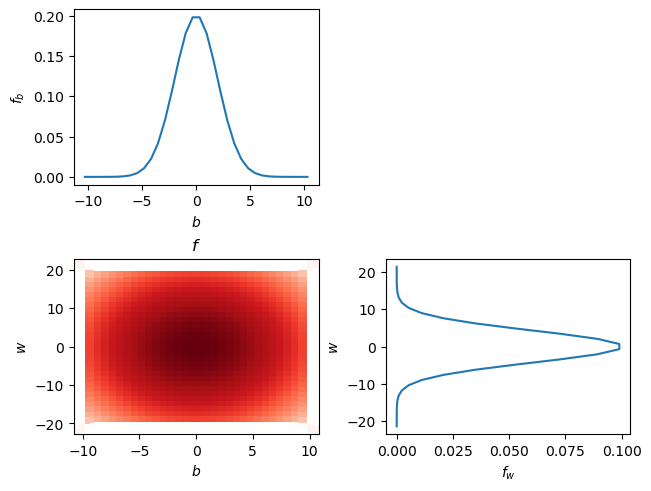

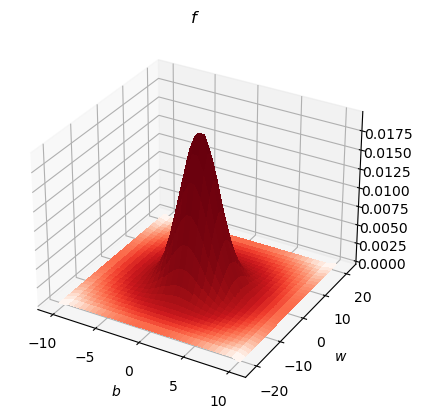

time t =  0.5
int f_12 dy1 dy2 =  0.9999957274542152


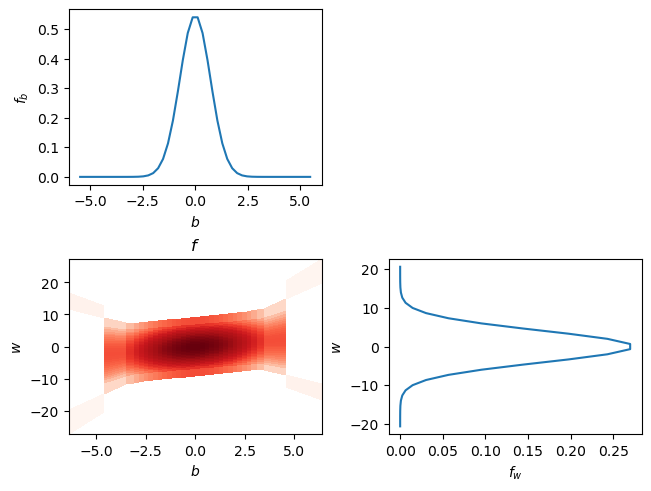

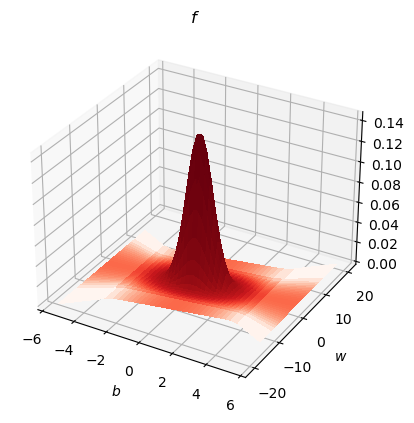

time t =  1.0
int f_12 dy1 dy2 =  0.9999957274542152


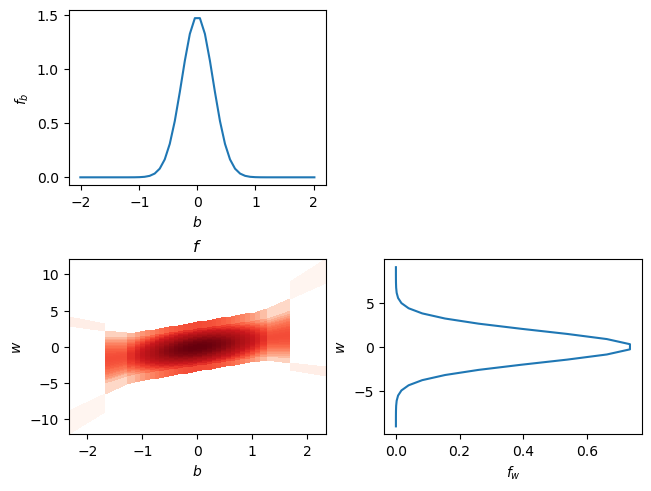

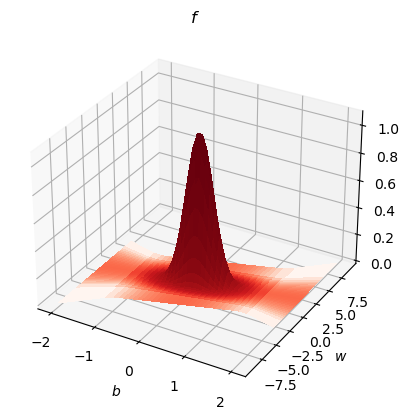

time t =  1.5
int f_12 dy1 dy2 =  0.9999957274542152


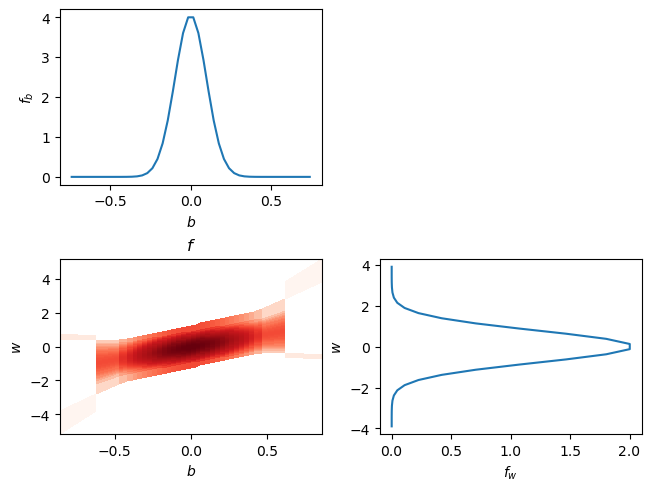

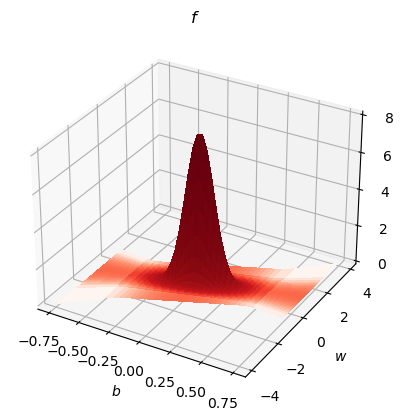

time t =  2.0
int f_12 dy1 dy2 =  0.9999957274576773


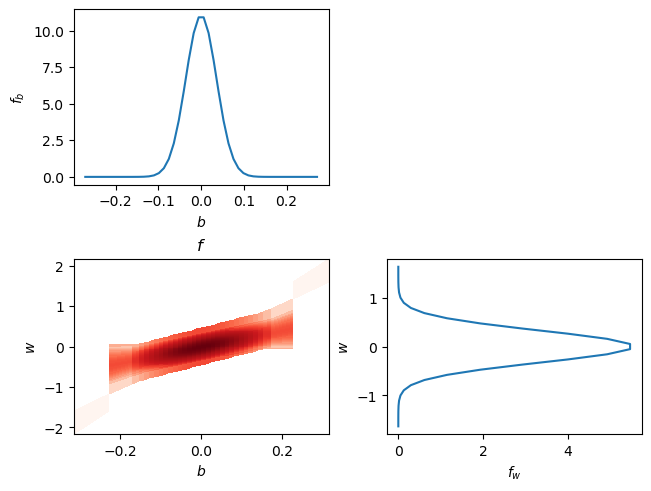

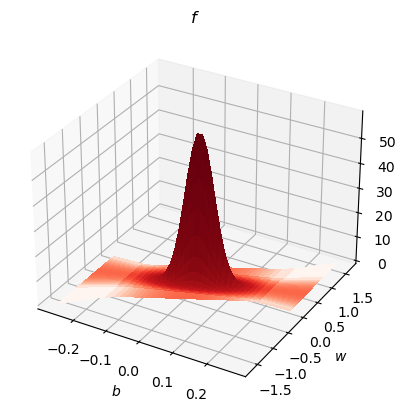

time t =  2.5
int f_12 dy1 dy2 =  0.9999957275492399


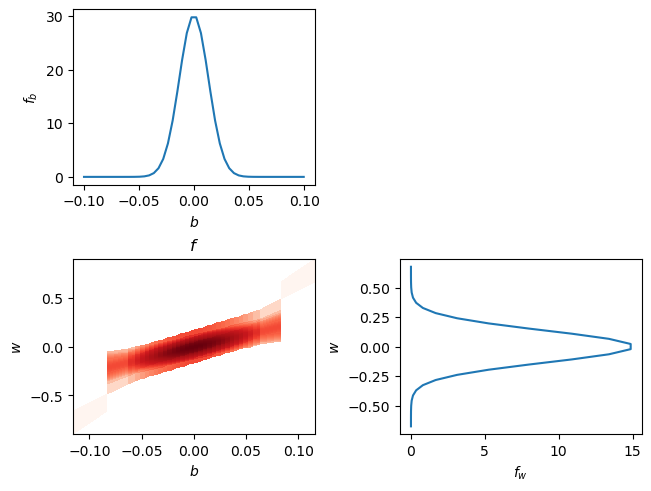

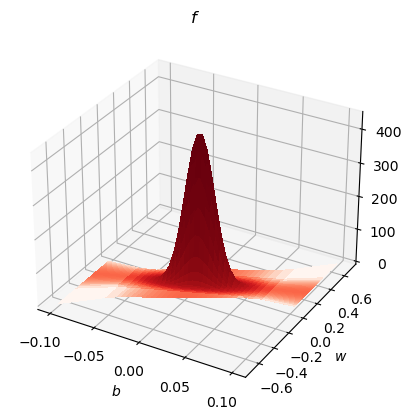

time t =  3.0
int f_12 dy1 dy2 =  0.9999957284934253


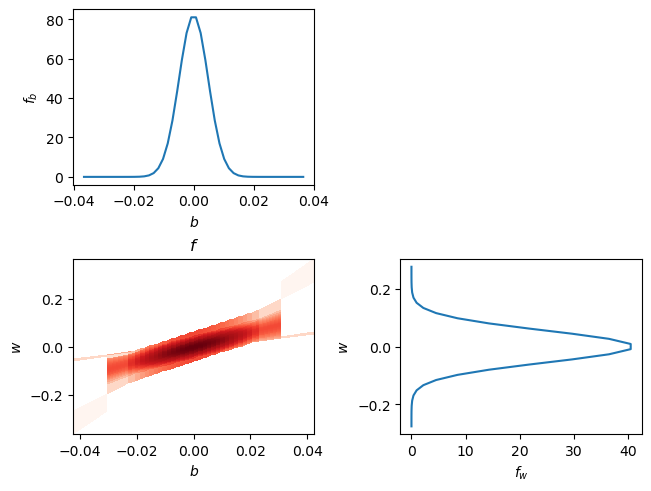

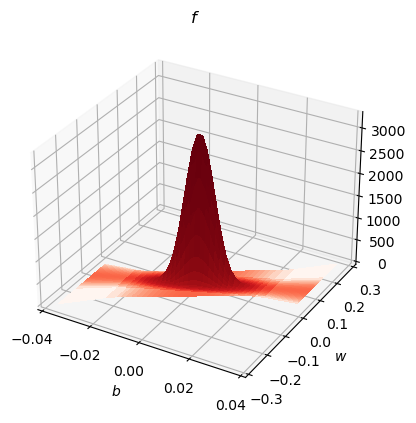

time t =  3.5
int f_12 dy1 dy2 =  0.9999957349475057


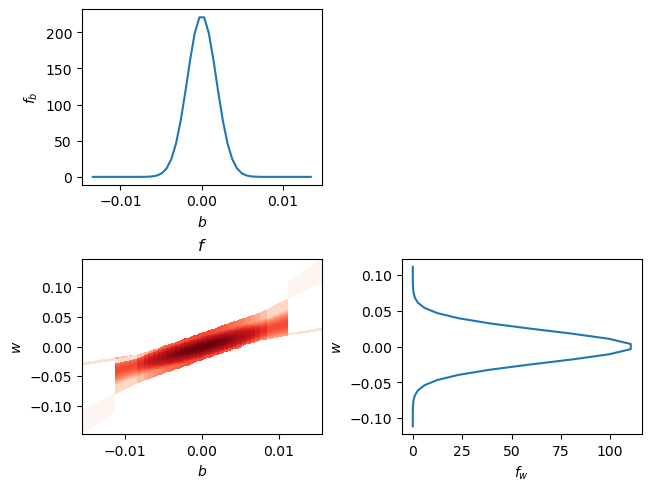

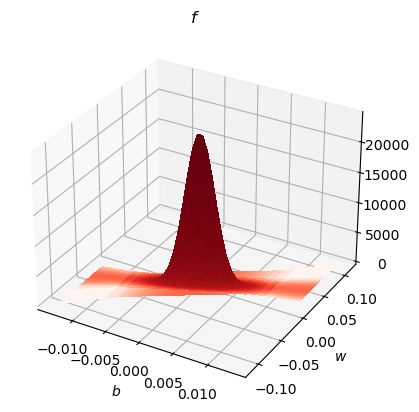

time t =  4.0
int f_12 dy1 dy2 =  0.9999957443797838


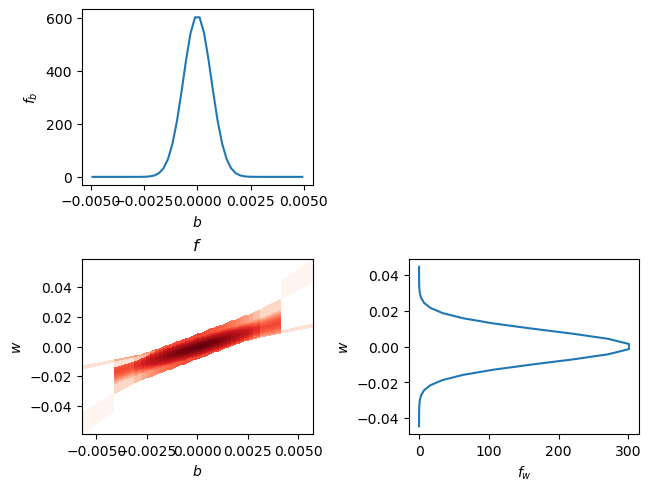

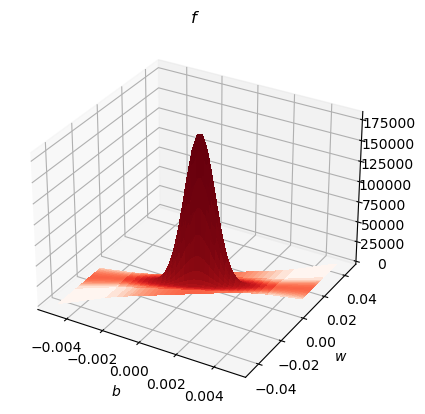

time t =  4.5
int f_12 dy1 dy2 =  0.9999957610410641


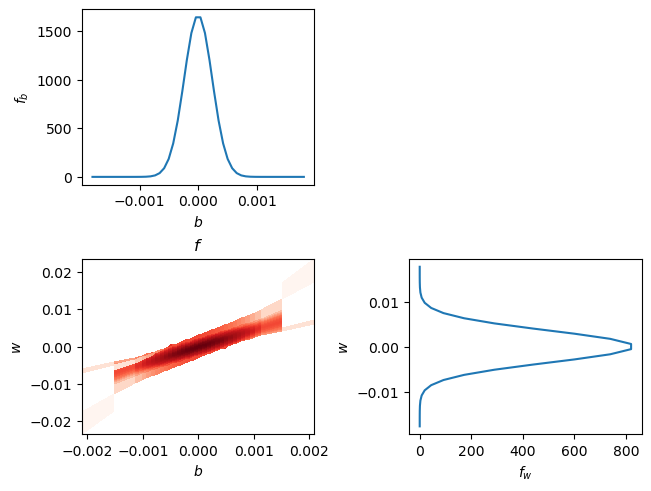

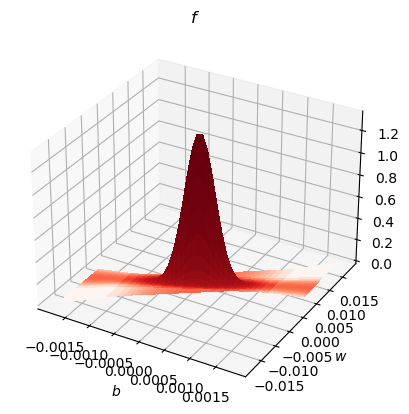

In [19]:
# Standard deviations for initial condition
σ1 = 2
Y1 = (erfinv(2*G(z1) - 1)*σ1*np.sqrt(2))

σ2 = 4
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

T  = 5 
dt = 0.0025
nt = int(T/dt)

def EY2_cY1(Y1,Y2):

    dY1_dη1 = one_to_2d(D1_1d@Y1) 
    dY2_dη2 = D2_2d@Y2
    g_2     = g(z2_2d).flatten()
    Y1      = one_to_2d(Y1)

    expr  = Y1*g_2*dY1_dη1/dY2_dη2
    c_avg = trapz(y=expr.reshape((N1,N2)),x=z1,axis=0)

    return np.kron(I1,c_avg) 


for i in range(nt):

    # Calculate expectation
    E_B_dPz = one_to_2d(Y1) - EY2_cY1(Y1,Y2)
    
    Y1 +=             L1 @ Y1  * dt
    Y2 +=  (E_B_dPz + L2 @ Y2) * dt
    
    if i % (nt/10) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)

*Bimodal PDF*

Lastly we now consider a case where $\bm{D}^{(1)}_1$ corresponds to a forcing that supports a 2 layer stratification. Importing routines from the 1D problem we first generate a bimodal pdf corresponding to a 2 layer stratification.

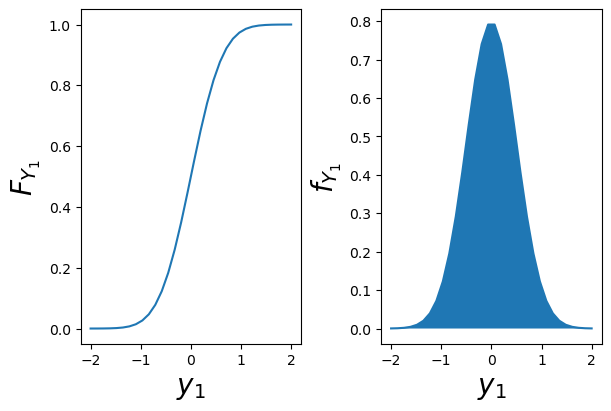

In [20]:
# A) Generate a PDF corresponding to a two layer stratification
from forcing import make_F, make_f

# Location of 'interface(s)'
loc = [0]  # Mean/height of the layer
std = [0.5]  # Standard deviation of the layer, we must choose std large for numerical reasons
amp = [1 ]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

F_Y1 = make_F(loc, std, amp)
f_Y1 = make_f(loc, std, amp)

# Visualise
fig = plt.figure(figsize=(6,4),layout='constrained')

y = np.linspace(-2,2,N1) 

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(y, F_Y1(y))
ax1.set_ylabel(r'$F_{Y_1}$', fontsize=20)
ax1.set_xlabel(r'$y_1$', fontsize=20)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(y, f_Y1(y))
ax2.fill_between(y, f_Y1(y))
ax2.set_ylabel(r'$f_{Y_1}$', fontsize=20)
ax2.set_xlabel(r'$y_1$', fontsize=20)

plt.show()

We then generate the forcing term $\bm{D}^{(1)}_1$ and the map $\mathscr{Y}_1$ required to produce this pdf.

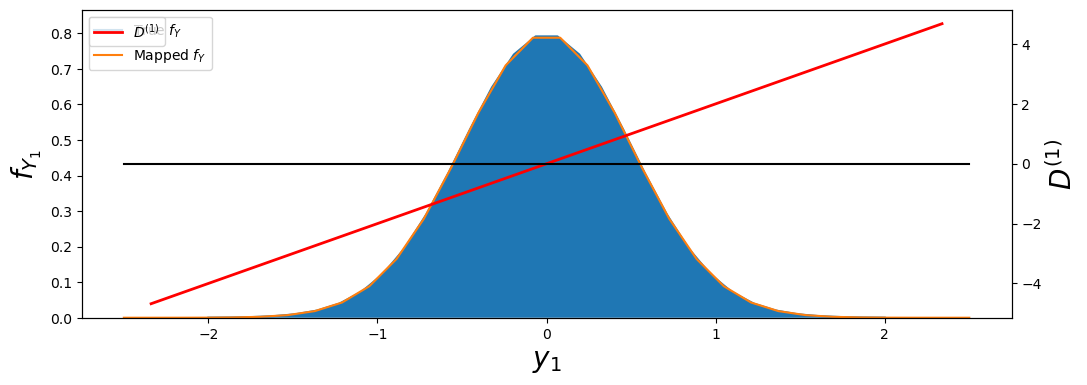

In [21]:
from scipy.optimize import root_scalar

# 3) Generate the map Y_map required to produce this pdf
def make_map(F, G, η):
    """Calculate the inverse of F"""
    Y_map = []
    for η_i in η:
        func = lambda x: F(x) - G(η_i)
        sol = root_scalar(func, bracket=[-10*max(η), 10*max(η)], method='brentq')
        Y_map.append(sol.root)
    return np.asarray(Y_map)

Y1_map = make_map(F=F_Y1, G=G, η=z1)

F1 = -L1@Y1_map # Here we use F1 instead of D^(1)_1 for the forcing as D has been used in code to refer to derivatives

# Check the mapped pdf matches
dY1_dz = grad(z1) @ Y1_map
f1_map = g(z1)/dY1_dz

fig = plt.figure(figsize=(12, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(y, f_Y1(y), label=r'True $f_Y$')
ax1.plot(Y1_map, f1_map, label=r'Mapped $f_Y$')
ax1.fill_between(Y1_map, f1_map)
#ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.1*np.max(f1_map)])
ax1.set_xlabel(r'$y_1$', fontsize=20)
ax1.set_ylabel(r'$f_{Y_1}$', fontsize=20)
ax1.legend(loc=2)

ax2.plot(Y1_map[1:-1], F1[1:-1], '-r', linewidth=2, label=r'$D^{(1)}$')
ax2.plot(Y1_map, 0*Y1_map, '-k')
#ax2.set_xlim([0, 1])
ax2.set_ylabel(r'$D^{(1)}$', fontsize=20)
ax2.legend()

plt.show()

Adding this forcing to the system we re-run the previous simulations starting from the same initial conditions.

time t =  0.0
int f_12 dy1 dy2 =  0.9999957274542152


/tmp/ipykernel_50232/4281687069.py:86: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax[1,0].pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds', norm='log')


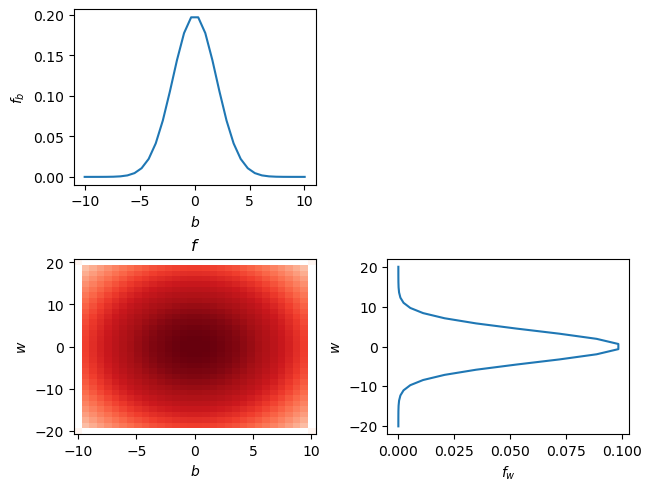

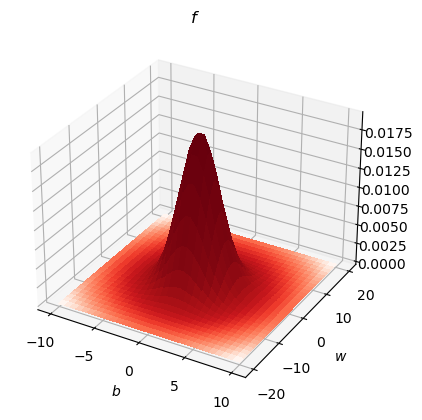

time t =  5.0
int f_12 dy1 dy2 =  0.9999749994527031


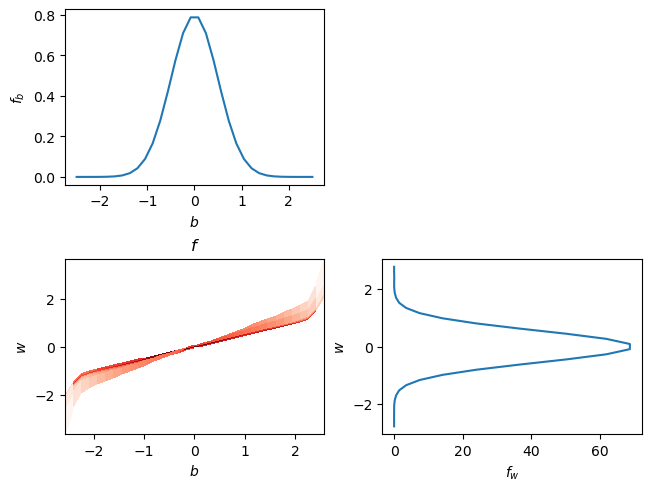

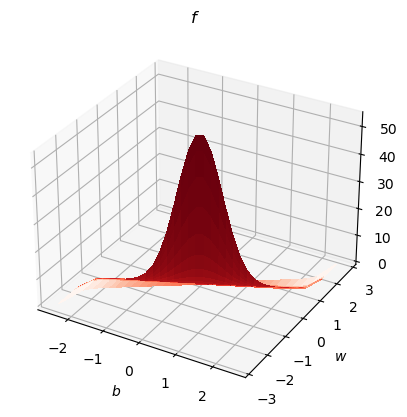

time t =  10.0
int f_12 dy1 dy2 =  0.9999749994527031


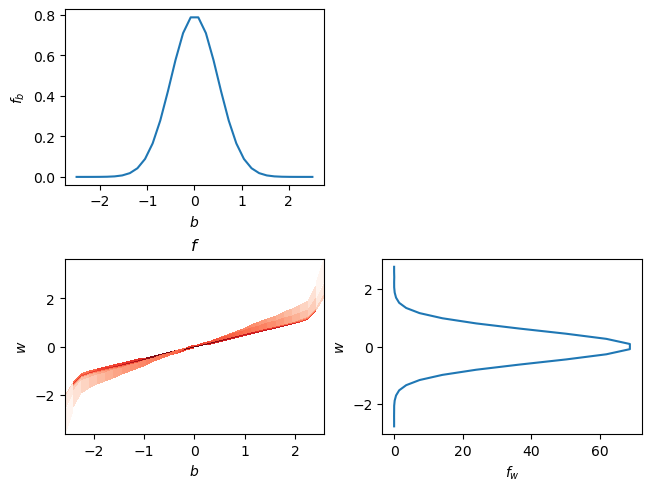

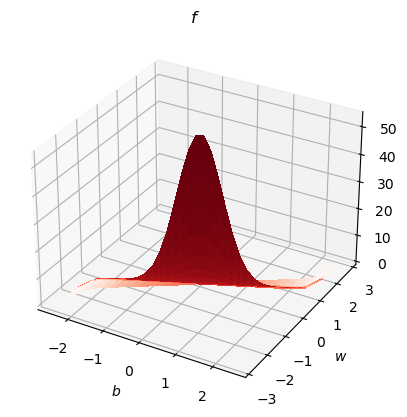

time t =  15.0
int f_12 dy1 dy2 =  0.9999749994527031


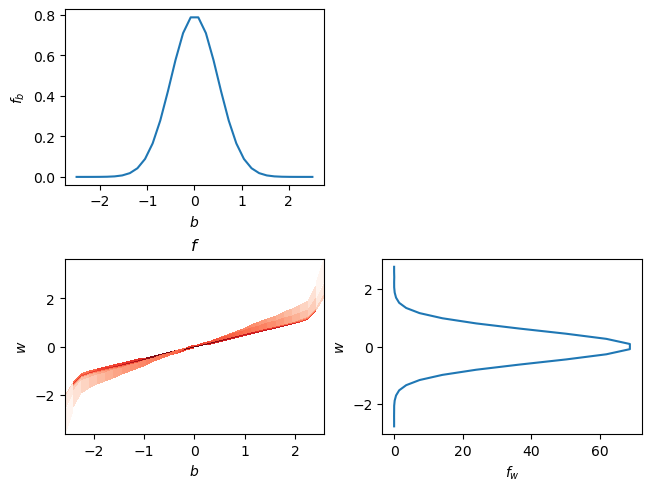

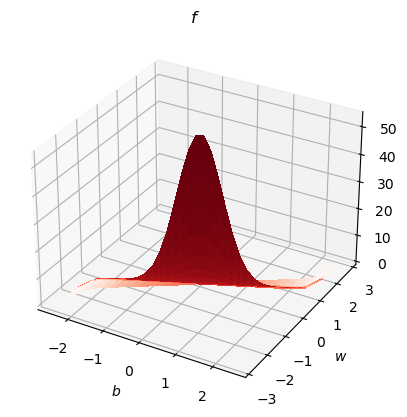

time t =  20.0
int f_12 dy1 dy2 =  0.9999749994527033


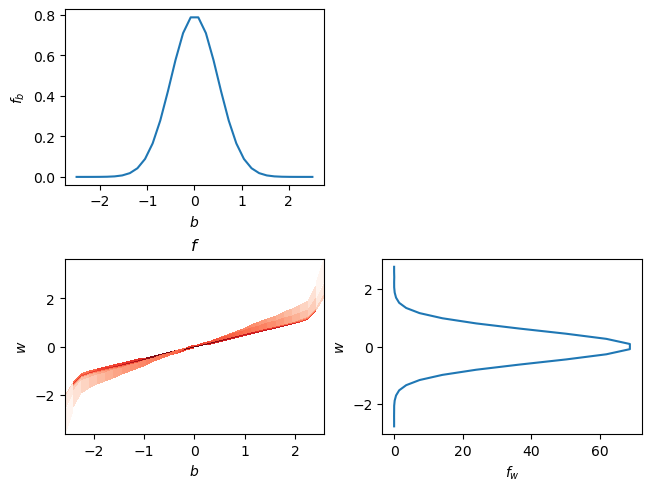

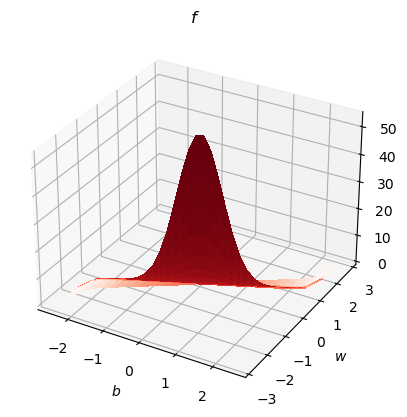

time t =  25.0
int f_12 dy1 dy2 =  0.9999749994527031


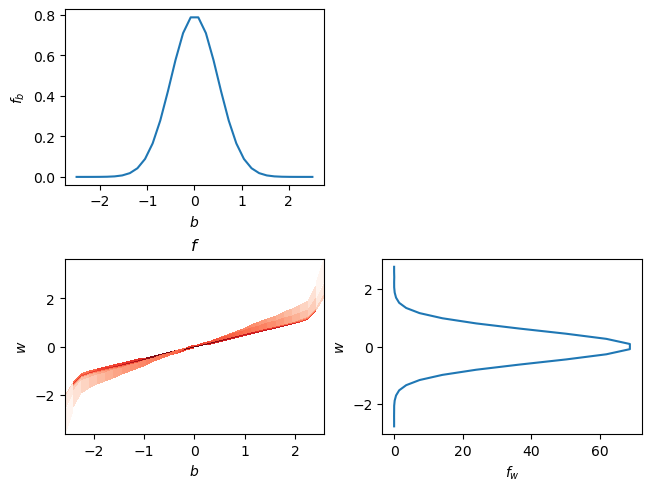

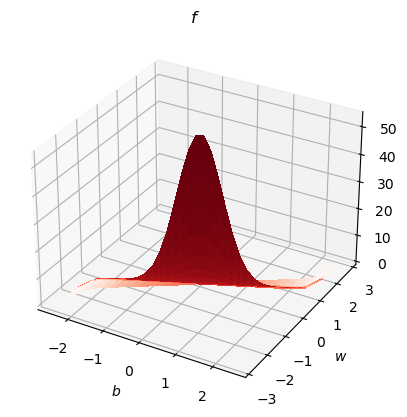

time t =  30.0
int f_12 dy1 dy2 =  0.9999749994527031


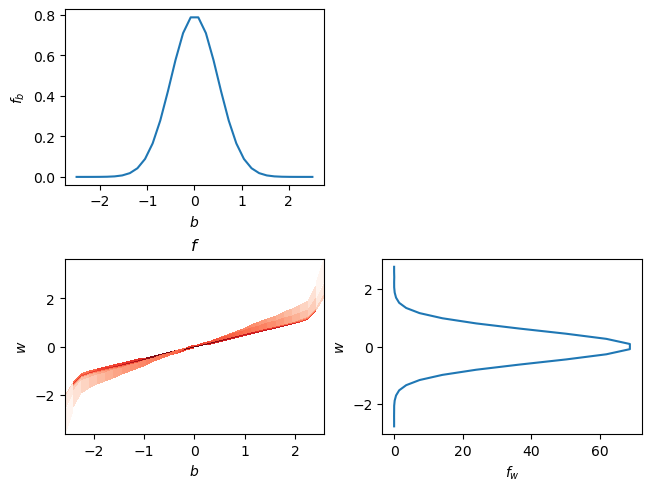

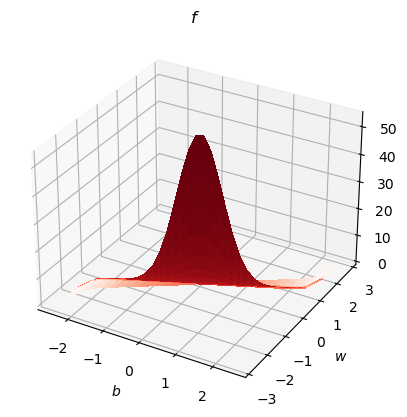

time t =  35.0
int f_12 dy1 dy2 =  0.9999749994527033


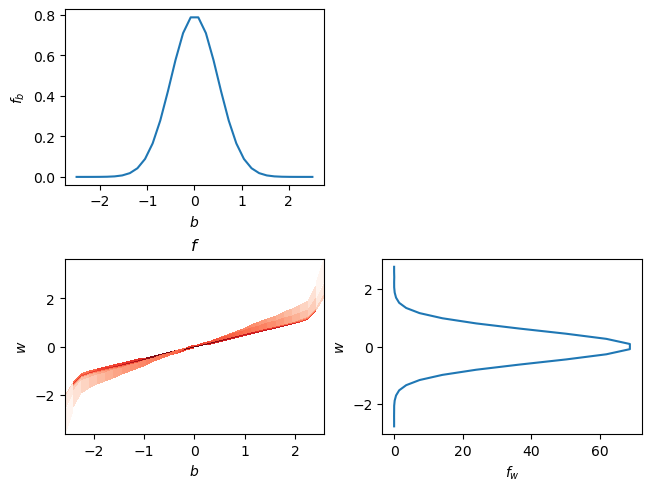

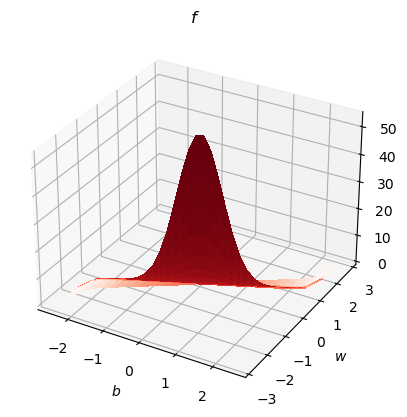

time t =  40.0
int f_12 dy1 dy2 =  0.9999749994527031


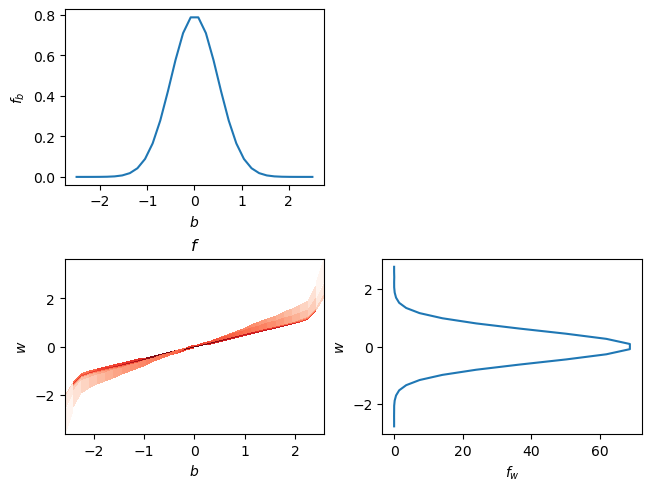

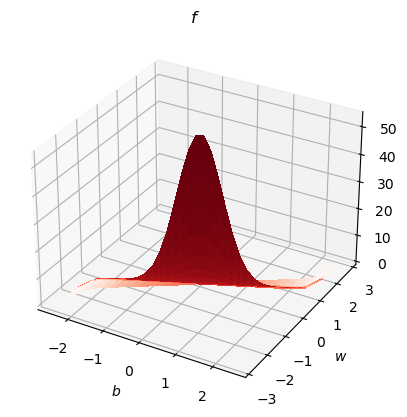

time t =  45.0
int f_12 dy1 dy2 =  0.9999749994527031


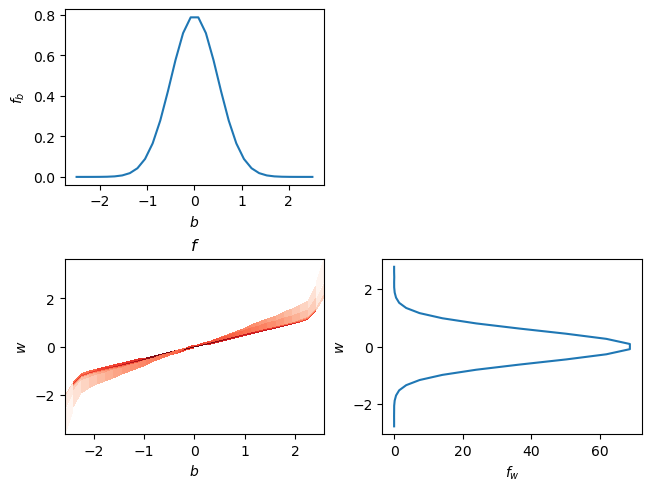

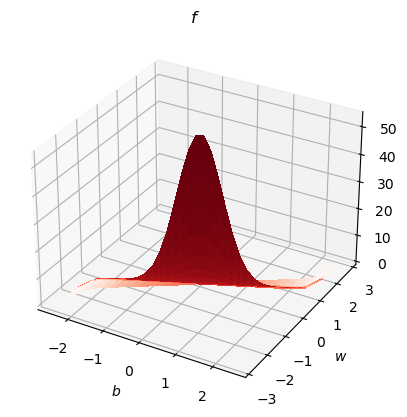

In [22]:
# Standard deviations for initial condition
σ1 = 2
Y1 = (erfinv(2*G(z1) - 1)*σ1*np.sqrt(2))

σ2 = 4
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

T  = 50 
dt = 0.00025
nt = int(T/dt)

for i in range(nt):

    # Calculate expectation
    E_B_dPz = one_to_2d(Y1) - EY2_cY1(Y1,Y2)
    
    # Update the fields
    Y1 +=  (F1      + L1 @ Y1) * dt
    Y2 +=  (E_B_dPz + L2 @ Y2) * dt
    
    if i % (nt/10) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)